# "Comparing GraphSAGE to CASC"

- toc:true
- branch: master
- badges: true
- comments: true
- author: Ze Ou
- categories: [fastpages, jupyter, CASC, GraphSAGE, graspologic]
- hide: false
- search_exclude: false

## Introduction

Hamilton et al. developed [GraphSAGE](http://snap.stanford.edu/graphsage/) to generate low-dimensional embeddings for nodes in large network. Unlike previous transductive method, GraphSAGE excels at generate embeddings for previously unseen nodes and graphs by leveraging node attribute information.{% fn 1 %}

On the other hand, Binkiewicz et al. developed [Covariate-assisted Spectral Clustering(CASC)](https://academic.oup.com/biomet/article/104/2/361/3074977) with a similar goal: use node covariates like node locations or neurological region memberships to help generate embeddings and identify latent communities in the graph.{% fn 2 %}

Since both methods utilize additional node information other than node connection to generate latent representations, it will be interesting to compare the two methods and observe their performance on various datasets.

## CORA Dataset

The [Cora dataset](https://linqs.soe.ucsc.edu/data) is the MNIST equivalent for graph learning and is often used for first testing purposes. It consists of 2708 scientific publications classified into one of seven classes. The citation network consists of 5429 links. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words.

In [1]:
import os
import networkx as nx
import pandas as pd
import graspologic
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


### Load the CORA Dataset

A is the $2708*2708$ adjacency matrix, X is the $2708*1433$ covariate matrix, and node_subjects is a $2708*1$ vector storing the category for each node. G_SAGE is the combination of A and X used for the Stellar GraphSAGE implementation.

In [2]:
from stellargraph import datasets

dataset = datasets.Cora()
G_SAGE, node_subjects_SAGE = dataset.load()
print(G_SAGE.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]
        Weights: all 1 (default)
        Features: none


In [3]:
A = graspologic.utils.import_graph(G_SAGE.to_networkx())
A = graspologic.utils.pass_to_ranks(A)
X = G_SAGE.node_features()
node_subjects_CASC = node_subjects_SAGE.reset_index()
node_subjects_CASC = node_subjects_CASC['subject'].squeeze()

### Search in alpha and n_components for CASC

We need to search in the parameter space of these two variables to determine an optimal combination for CASC.


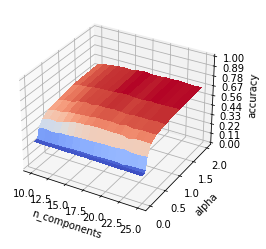

In [5]:
%matplotlib inline
from tensorflow.keras import layers, optimizers, losses, metrics, Model, Sequential, utils
from graspologic.embed import CovariateAssistedEmbed as CASE
from sklearn import preprocessing, model_selection
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator


# Split the dataset into training and testing
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects_CASC, train_size=0.1, test_size=None, stratify=node_subjects_CASC
)

target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
test_targets = target_encoding.transform(test_subjects)

# Define the search range
alpha_min=10e-5
alpha_max=2
alpha_num=20
components_min=10
components_max=25

components_num = components_max - components_min + 1
alpha_range = np.geomspace(alpha_min, alpha_max, alpha_num)
components_range = range(components_min, components_max+1)

test_loss = np.zeros((alpha_num, components_num))
test_acc = np.zeros((alpha_num, components_num))

for a, i in zip(alpha_range, range(0, alpha_num)):
    case = CASE(alpha=a, assortative=True, n_components=components_max)
    latents = case.fit_transform((A, X))
    for n, j in zip(components_range, range(0, components_num)):
        train_data = latents[train_subjects.index.values, 0:n]
        test_data = latents[test_subjects.index.values, 0:n]
        model = Sequential(
            layers.Dense(units=train_targets.shape[1], activation="softmax")
        )
        model.compile(
            optimizer=optimizers.Adam(lr=0.03),
            loss=losses.categorical_crossentropy,
            metrics=["acc"],
        )
        model.fit(train_data, train_targets, epochs=50, verbose=0)
        test_loss[i, j], test_acc[i, j] = model.evaluate(test_data,  test_targets, verbose=0)

components_range, alpha_range = np.meshgrid(components_range, alpha_range)
fig = plt.figure()
ax = plt.axes(projection='3d')

surf = ax.plot_surface(components_range, alpha_range, test_acc, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(0, 1)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

ax.set_xlabel('n_components')
ax.set_ylabel('alpha')
ax.set_zlabel('accuracy');

Based on the search, we can safely says that a combination of alpha=2 and n_components=25 will give us a good performance for CASC

### K-Fold Validation for GraphSAGE and CASC

In [6]:
from stellargraph.mapper import GraphSAGENodeGenerator
from stellargraph.layer import GraphSAGE

num_folds = 10
# The first column corresponds to GraphSAGE, the second column corresponds to CASC
acc_per_fold = np.zeros((num_folds, 2))
loss_per_fold = np.zeros((num_folds, 2))

# Parameters specific for GraphSAGE
batch_size = 50
num_samples = [10, 5]  
generator = GraphSAGENodeGenerator(G_SAGE, batch_size, num_samples)

# Parameters specific for CASC
alpha = 2
n_components = 25

# Calculate latent positions for CASC
case = CASE(alpha=alpha, assortative=True, n_components=n_components)
latents = case.fit_transform((A, X))

skf = model_selection.StratifiedKFold(n_splits=num_folds)

fold_no = 1
for train_index, test_index in skf.split(np.zeros(2708), node_subjects_CASC):

    # GraphSAGE

    # Separate the dataset into training and testing
    train_subjects = node_subjects_SAGE.iloc[train_index]
    test_subjects = node_subjects_SAGE.iloc[test_index]

    # Convert the labels into one-hot vectors
    target_encoding = preprocessing.LabelBinarizer()
    train_targets = target_encoding.fit_transform(train_subjects)
    test_targets = target_encoding.transform(test_subjects)

    train_gen = generator.flow(train_subjects.index, train_targets, shuffle=True)

    graphsage_model = GraphSAGE(
        layer_sizes=[32, 32], generator=generator, bias=True, dropout=0.5,
    )

    x_inp, x_out = graphsage_model.in_out_tensors()
    prediction = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

    model = Model(inputs=x_inp, outputs=prediction)
    model.compile(
        optimizer=optimizers.Adam(lr=0.005),
        loss=losses.categorical_crossentropy,
        metrics=["acc"],
    )
    model.fit(train_gen, epochs=20, verbose=0, shuffle=False)
    test_gen = generator.flow(test_subjects.index, test_targets)
    test_loss, test_acc = model.evaluate(test_gen, verbose=0)
    print(f'GraphSAGE: Score for fold {fold_no}: {model.metrics_names[0]} of {test_loss}; {model.metrics_names[1]} of {test_acc}')
    acc_per_fold[fold_no-1, 0] = test_acc
    loss_per_fold[fold_no-1, 0] = test_loss

    # CASC
    train_data = latents[train_index, :]
    test_data = latents[test_index, :]

    model = Sequential(
        layers.Dense(units=train_targets.shape[1], activation="softmax")
    )
    model.compile(
        optimizer=optimizers.Adam(lr=0.03),
        loss=losses.categorical_crossentropy,
        metrics=["acc"],
    )
    model.fit(train_data, train_targets, epochs=80, verbose=0)
    test_loss, test_acc = model.evaluate(test_data,  test_targets, verbose=0)

    print(f'CASC: Score for fold {fold_no}: {model.metrics_names[0]} of {test_loss}; {model.metrics_names[1]} of {test_acc}')
    acc_per_fold[fold_no-1, 1] = test_acc
    loss_per_fold[fold_no-1, 1] = test_loss

    # Increase fold number
    fold_no = fold_no + 1

    print()

GraphSAGE: Score for fold 1: loss of 0.5386274456977844; acc of 0.8523985147476196
CASC: Score for fold 1: loss of 0.8901646137237549; acc of 0.76752769947052

GraphSAGE: Score for fold 2: loss of 0.5524826049804688; acc of 0.8560885787010193
CASC: Score for fold 2: loss of 0.7989338040351868; acc of 0.7343173623085022

GraphSAGE: Score for fold 3: loss of 0.47200965881347656; acc of 0.8819188475608826
CASC: Score for fold 3: loss of 0.729191780090332; acc of 0.7638376355171204

GraphSAGE: Score for fold 4: loss of 0.5235143899917603; acc of 0.8523985147476196
CASC: Score for fold 4: loss of 0.7496111392974854; acc of 0.7306272983551025

GraphSAGE: Score for fold 5: loss of 0.552318811416626; acc of 0.8413284420967102
CASC: Score for fold 5: loss of 0.8455246686935425; acc of 0.7343173623085022

GraphSAGE: Score for fold 6: loss of 0.5929430723190308; acc of 0.8376383781433105
CASC: Score for fold 6: loss of 0.8899222016334534; acc of 0.6937269568443298

GraphSAGE: Score for fold 7: lo

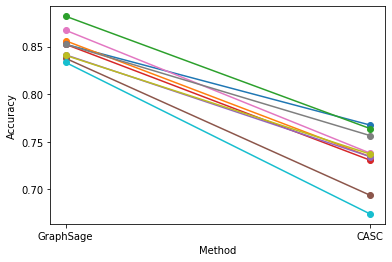

In [7]:
ax = plt.gca()
for i in range(0, 10):
    plt.plot([1, 2], [acc_per_fold[i, 0], acc_per_fold[i, 1]], marker='o')
ax.set_xlabel('Method')
ax.set_ylabel('Accuracy')
ax.set_xticks([1, 2])
ax.set_xticklabels(['GraphSage', 'CASC']);

### GraphSAGE Confusion Matrix

In [8]:
#collapse
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects_SAGE, train_size=0.1, test_size=None, stratify=node_subjects_SAGE
)

target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
test_targets = target_encoding.transform(test_subjects)

generator = GraphSAGENodeGenerator(G_SAGE, batch_size, num_samples)

train_gen = generator.flow(train_subjects.index, train_targets, shuffle=True)

graphsage_model = GraphSAGE(
    layer_sizes=[32, 32], generator=generator, bias=True, dropout=0.5,
)

x_inp, x_out = graphsage_model.in_out_tensors()
prediction = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

model = Model(inputs=x_inp, outputs=prediction)
model.compile(
    optimizer=optimizers.Adam(lr=0.005),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)
model.fit(train_gen, epochs=20, verbose=0, shuffle=False)

all_nodes = node_subjects_SAGE.index
all_mapper = generator.flow(all_nodes)
all_predictions = model.predict(all_mapper)
node_predictions = target_encoding.inverse_transform(all_predictions)

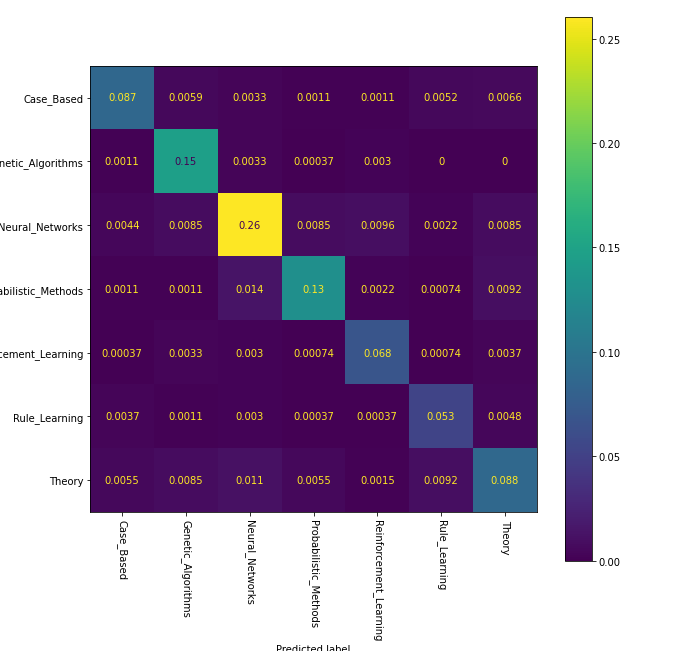

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

figure, ax = plt.subplots(figsize=(10, 10))
cm = confusion_matrix(node_subjects_SAGE, node_predictions, labels=['Case_Based', 'Genetic_Algorithms', 'Neural_Networks',
       'Probabilistic_Methods', 'Reinforcement_Learning', 'Rule_Learning',
       'Theory'], normalize='all')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Case_Based', 'Genetic_Algorithms', 'Neural_Networks',
       'Probabilistic_Methods', 'Reinforcement_Learning', 'Rule_Learning',
       'Theory'])
disp.plot(ax=ax, xticks_rotation=270);

### CASC Confusion Matrix

In [10]:
#collapse
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects_CASC, train_size=0.1, test_size=None, stratify=node_subjects_CASC
)

target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
test_targets = target_encoding.transform(test_subjects)

train_data = latents[train_subjects.index.values, :]
test_data = latents[test_subjects.index.values, :]

model = Sequential(
    layers.Dense(units=train_targets.shape[1], activation="softmax")
)

model.compile(
    optimizer=optimizers.Adam(lr=0.03),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

model.fit(train_data, train_targets, epochs=50, verbose=0)

all_predictions = model.predict(latents)
node_predictions = target_encoding.inverse_transform(all_predictions)

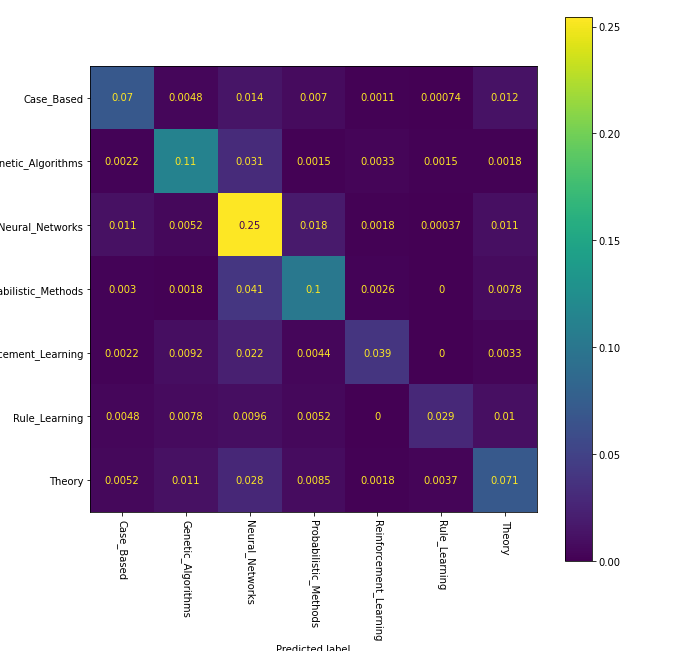

In [11]:
figure, ax = plt.subplots(figsize=(10, 10))
cm = confusion_matrix(node_subjects_CASC, node_predictions, labels=['Case_Based', 'Genetic_Algorithms', 'Neural_Networks',
       'Probabilistic_Methods', 'Reinforcement_Learning', 'Rule_Learning',
       'Theory'], normalize='all')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Case_Based', 'Genetic_Algorithms', 'Neural_Networks',
       'Probabilistic_Methods', 'Reinforcement_Learning', 'Rule_Learning',
       'Theory'])
disp.plot(ax=ax, xticks_rotation=270);

## PubMed Diabetes Dataset 

The [Pubmed Diabetes dataset](https://linqs.soe.ucsc.edu/data) consists of 19717 scientific publications from PubMed database pertaining to diabetes classified into one of three classes. The citation network consists of 44338 links. Each publication in the dataset is described by a TF/IDF weighted word vector from a dictionary which consists of 500 unique words.

Similar to the CORA dataset, the PubMed Diabetes dataset is about scientific paper citation. However, there are only 3 categories compared to 7. There are also more nodes. The feature vector is also non-binary. 

### Load the PubMed Diabetes Dataset

A is the $19717*19717$ adjacency matrix, X is the $19717*500$ covariate matrix, and node_subjects is a $19717*1$ vector storing the category for each node. G_SAGE is the combination of A and X used for the Stellar GraphSAGE implementation.

In [12]:
%reset

In [15]:
import os
import networkx as nx
import pandas as pd
import graspologic
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [16]:
from stellargraph import datasets

dataset = datasets.PubMedDiabetes()
G_SAGE, node_subjects_SAGE = dataset.load()
print(G_SAGE.info())

StellarGraph: Undirected multigraph
 Nodes: 19717, Edges: 44338

 Node types:
  paper: [19717]
    Features: float32 vector, length 500
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [44338]
        Weights: all 1 (default)
        Features: none


In [17]:
A = graspologic.utils.import_graph(G_SAGE.to_networkx())
A = graspologic.utils.pass_to_ranks(A)
X = G_SAGE.node_features()
node_subjects_CASC = node_subjects_SAGE.reset_index()
node_subjects_CASC = node_subjects_CASC['label'].squeeze()

In [18]:
def plot_latents(latent_positions, *, title, labels, ax=None):
    if ax is None:
        ax = plt.gca()
    plot = sns.scatterplot(latent_positions[:, 0], latent_positions[:, 1], hue=labels, 
                           linewidth=0, s=10, ax=ax, palette="Set1")
    plot.set_title(title, wrap=True);
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    ax.legend(bbox_to_anchor=(1.5, 1), loc="upper right", title="Community")
    
    return plot

/Users/ze/opt/miniconda3/envs/Stellar/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


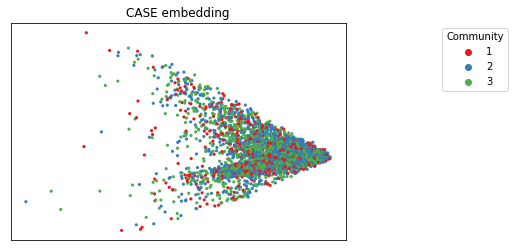

In [19]:
from graspologic.embed import CovariateAssistedEmbed as CASE

case = CASE(alpha=None, assortative=True, n_components=2)
latents = case.fit_transform((A, X))
plot_latents(latents, title=r"CASE embedding", labels=node_subjects_CASC);

In [20]:
print("The ratio of the leading eigenvector is:", case.alpha_)

The ratio of the leading eigenvector is: 0.016129894022840232


### Search in alpha and n_components for CASC

We need to search in the parameter space of these two variables to determine an optimal combination for CASC.


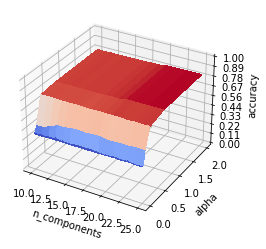

In [21]:
#collapse
%matplotlib inline
from tensorflow.keras import layers, optimizers, losses, metrics, Model, Sequential, utils
from graspologic.embed import CovariateAssistedEmbed as CASE
from sklearn import preprocessing, model_selection
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator


# Split the dataset into training and testing
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects_CASC, train_size=0.1, test_size=None, stratify=node_subjects_CASC
)

target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
test_targets = target_encoding.transform(test_subjects)

# Define the search range
alpha_min=10e-5
alpha_max=2
alpha_num=10
components_min=10
components_max=25

components_num = components_max - components_min + 1
alpha_range = np.geomspace(alpha_min, alpha_max, alpha_num)
components_range = range(components_min, components_max+1)

test_loss = np.zeros((alpha_num, components_num))
test_acc = np.zeros((alpha_num, components_num))

for a, i in zip(alpha_range, range(0, alpha_num)):
    case = CASE(alpha=a, assortative=True, n_components=components_max)
    latents = case.fit_transform((A, X))
    for n, j in zip(components_range, range(0, components_num)):
        train_data = latents[train_subjects.index.values, 0:n]
        test_data = latents[test_subjects.index.values, 0:n]
        model = Sequential(
            layers.Dense(units=train_targets.shape[1], activation="softmax")
        )
        model.compile(
            optimizer=optimizers.Adam(lr=0.03),
            loss=losses.categorical_crossentropy,
            metrics=["acc"],
        )
        model.fit(train_data, train_targets, epochs=50, verbose=0)
        test_loss[i, j], test_acc[i, j] = model.evaluate(test_data,  test_targets, verbose=0)

components_range, alpha_range = np.meshgrid(components_range, alpha_range)
fig = plt.figure()
ax = plt.axes(projection='3d')

surf = ax.plot_surface(components_range, alpha_range, test_acc, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(0, 1)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

ax.set_xlabel('n_components')
ax.set_ylabel('alpha')
ax.set_zlabel('accuracy');

Based on the search, we can safely says that a combination of alpha=2 and n_components=25 will give us a good performance for CASC

### K-Fold Validation for GraphSAGE and CASC

GraphSAGE: Score for fold 1: loss of 0.27281248569488525; acc of 0.9031440019607544
CASC: Score for fold 1: loss of 0.4590357542037964; acc of 0.8154157996177673

GraphSAGE: Score for fold 2: loss of 0.2910495102405548; acc of 0.8848884105682373
CASC: Score for fold 2: loss of 0.4615432322025299; acc of 0.8149087429046631

GraphSAGE: Score for fold 3: loss of 0.29778361320495605; acc of 0.8950304388999939
CASC: Score for fold 3: loss of 0.45043161511421204; acc of 0.8154157996177673

GraphSAGE: Score for fold 4: loss of 0.28901612758636475; acc of 0.889452338218689
CASC: Score for fold 4: loss of 0.43810975551605225; acc of 0.8215010166168213

GraphSAGE: Score for fold 5: loss of 0.31633561849594116; acc of 0.8828600645065308
CASC: Score for fold 5: loss of 0.46598654985427856; acc of 0.813894510269165

GraphSAGE: Score for fold 6: loss of 0.2792716324329376; acc of 0.8843813538551331
CASC: Score for fold 6: loss of 0.4625921845436096; acc of 0.8062880039215088

GraphSAGE: Score for fo

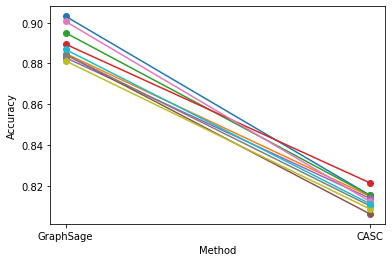

In [22]:
#collapse
from stellargraph.mapper import GraphSAGENodeGenerator
from stellargraph.layer import GraphSAGE

num_folds = 10
# The first column corresponds to GraphSAGE, the second column corresponds to CASC
acc_per_fold = np.zeros((num_folds, 2))
loss_per_fold = np.zeros((num_folds, 2))

# Parameters specific for GraphSAGE
batch_size = 50
num_samples = [10, 5]  
generator = GraphSAGENodeGenerator(G_SAGE, batch_size, num_samples)

# Parameters specific for CASC
alpha = 2
n_components = 25

# Calculate latent positions for CASC
case = CASE(alpha=alpha, assortative=True, n_components=n_components)
latents = case.fit_transform((A, X))

skf = model_selection.StratifiedKFold(n_splits=num_folds)

fold_no = 1
for train_index, test_index in skf.split(np.zeros(19717), node_subjects_CASC):

    # GraphSAGE

    # Separate the dataset into training and testing
    train_subjects = node_subjects_SAGE.iloc[train_index]
    test_subjects = node_subjects_SAGE.iloc[test_index]

    # Convert the labels into one-hot vectors
    target_encoding = preprocessing.LabelBinarizer()
    train_targets = target_encoding.fit_transform(train_subjects)
    test_targets = target_encoding.transform(test_subjects)

    train_gen = generator.flow(train_subjects.index, train_targets, shuffle=True)

    graphsage_model = GraphSAGE(
        layer_sizes=[32, 32], generator=generator, bias=True, dropout=0.5,
    )

    x_inp, x_out = graphsage_model.in_out_tensors()
    prediction = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

    model = Model(inputs=x_inp, outputs=prediction)
    model.compile(
        optimizer=optimizers.Adam(lr=0.005),
        loss=losses.categorical_crossentropy,
        metrics=["acc"],
    )
    model.fit(train_gen, epochs=20, verbose=0, shuffle=False)
    test_gen = generator.flow(test_subjects.index, test_targets)
    test_loss, test_acc = model.evaluate(test_gen, verbose=0)
    print(f'GraphSAGE: Score for fold {fold_no}: {model.metrics_names[0]} of {test_loss}; {model.metrics_names[1]} of {test_acc}')
    acc_per_fold[fold_no-1, 0] = test_acc
    loss_per_fold[fold_no-1, 0] = test_loss

    # CASC
    train_data = latents[train_index, :]
    test_data = latents[test_index, :]

    model = Sequential(
        layers.Dense(units=train_targets.shape[1], activation="softmax")
    )
    model.compile(
        optimizer=optimizers.Adam(lr=0.03),
        loss=losses.categorical_crossentropy,
        metrics=["acc"],
    )
    model.fit(train_data, train_targets, epochs=80, verbose=0)
    test_loss, test_acc = model.evaluate(test_data,  test_targets, verbose=0)

    print(f'CASC: Score for fold {fold_no}: {model.metrics_names[0]} of {test_loss}; {model.metrics_names[1]} of {test_acc}')
    acc_per_fold[fold_no-1, 1] = test_acc
    loss_per_fold[fold_no-1, 1] = test_loss

    # Increase fold number
    fold_no = fold_no + 1

    print()

ax = plt.gca()
for i in range(0, num_folds):
    plt.plot([1, 2], [acc_per_fold[i, 0], acc_per_fold[i, 1]], marker='o')
ax.set_xlabel('Method')
ax.set_ylabel('Accuracy')
ax.set_xticks([1, 2])
ax.set_xticklabels(['GraphSage', 'CASC']);

### GraphSAGE Confusion Matrix

In [23]:
#collapse
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects_SAGE, train_size=0.1, test_size=None, stratify=node_subjects_SAGE
)

target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
test_targets = target_encoding.transform(test_subjects)

generator = GraphSAGENodeGenerator(G_SAGE, batch_size, num_samples)

train_gen = generator.flow(train_subjects.index, train_targets, shuffle=True)

graphsage_model = GraphSAGE(
    layer_sizes=[32, 32], generator=generator, bias=True, dropout=0.5,
)

x_inp, x_out = graphsage_model.in_out_tensors()
prediction = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

model = Model(inputs=x_inp, outputs=prediction)
model.compile(
    optimizer=optimizers.Adam(lr=0.005),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)
model.fit(train_gen, epochs=20, verbose=0, shuffle=False)

all_nodes = node_subjects_SAGE.index
all_mapper = generator.flow(all_nodes)
all_predictions = model.predict(all_mapper)
node_predictions = target_encoding.inverse_transform(all_predictions)

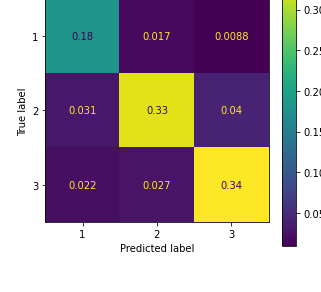

In [24]:
#collapse
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

figure, ax = plt.subplots(figsize=(5, 5))
cm = confusion_matrix(node_subjects_SAGE, node_predictions, labels=[1, 2, 3], normalize='all')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 2, 3])
disp.plot(ax=ax);

### CASC Confusion Matrix

In [25]:
#collapse
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects_CASC, train_size=0.1, test_size=None, stratify=node_subjects_CASC
)

target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
test_targets = target_encoding.transform(test_subjects)

train_data = latents[train_subjects.index.values, :]
test_data = latents[test_subjects.index.values, :]

model = Sequential(
    layers.Dense(units=train_targets.shape[1], activation="softmax")
)

model.compile(
    optimizer=optimizers.Adam(lr=0.03),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

model.fit(train_data, train_targets, epochs=50, verbose=0)

all_predictions = model.predict(latents)
node_predictions = target_encoding.inverse_transform(all_predictions)

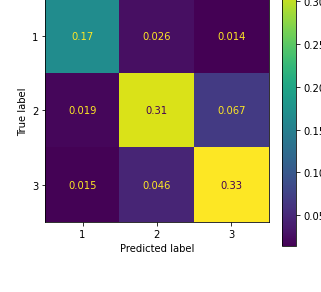

In [26]:
#collapse
figure, ax = plt.subplots(figsize=(5, 5))
cm = confusion_matrix(node_subjects_CASC, node_predictions, labels=[1, 2, 3], normalize='all')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 2, 3])
disp.plot(ax=ax);

## Conclusion

Based on the results from the two datasets, we can comfortably say that CASC is about 10% less accurate than GraphSAGE. However, we did not perform an extensive search in the alpha and n_components space to find the global maximum pair of parameters. We simply did a logarithmic search around the raiot of the largest eigenvectors. It might be possible that we were not successful in locating the most optimal setting with our grid search algorithm.

It is worth noting that the accuracy of classification based on CASC embedding seems to monotonically increases with both n_components and alpha. It is easy to understand the case of n_components. As n_components increase, the nodes are embedded into higher dimensions, separating the clusters further apart. However, the monotinic increase with alpha seems to imply that the adjacency matrix matters less than the feature matrix in both datasets tested here.

It is also worth noting that while the run times of both methods for CORA are similar, CASC is significantly slower than GraphSAGE for PubMed Diabetes due to the large number of nodes to be embedded. Furthermore, GraphSAGE is an inductive method, but CASC needs to embed the entire graph again when classifying previously unseen nodes.

{{ 'The GraphSAGE implementation used for this notebook is from [StellarGraph](https://stellargraph.readthedocs.io/en/stable/demos/node-classification/graphsage-node-classification.html)'  | fndetail: 1 }}

{{ 'The CASC implementation used for this notebook is from [Alex Loftus Commit 0190a55403ec4c529e4a36bc8fa0fd3fb49fe7d4](https://github.com/loftusa/graspologic/tree/0190a55403ec4c529e4a36bc8fa0fd3fb49fe7d4)'  | fndetail: 1 }}